# Laboratory notebook
This notebook is where you can experiment using the subtractive solver on multiple repositories yourself!
Add the repo url (from either a remote git repository, or a local path) and the branch you want to analyze (defaults to main).
I have set up an example setup that allows you to just add repo paths to a list and the notebook will concurrently analyze all the 
repositories and display them in a chart.

In [1]:
from dataclasses import dataclass

@dataclass
class RepoRef():
    repo_path: str
    branch: str = "main"

In [2]:
repos: list[RepoRef] = [
    RepoRef(repo_path="https://github.com/googleapis/googleapis", branch="master"),
    RepoRef(repo_path="https://github.com/googleapis/google-api-nodejs-client", branch="main"),
    RepoRef(repo_path="https://github.com/danielmiessler/fabric", branch="main"),
    RepoRef(repo_path="https://github.com/toss/es-toolkit", branch="main"),
    RepoRef(repo_path="https://github.com/freeCodeCamp/freeCodeCamp", branch="main"),
    RepoRef(repo_path="https://github.com/ohmyzsh/ohmyzsh", branch="master"),
    RepoRef(repo_path="https://github.com/electron/electron", branch="main"),
]

## Fetching and analyzing 
It seems the GitPython is not exaclty thread safe. If you figure out how to run this concurrently, good job.
For now, we'll have to run this sequentially

In [3]:
from multiprocessing.pool import ThreadPool
from tqdm import tqdm
from typing import List
from main import main

@dataclass
class Result():
    repo_name: str
    num_problem_solved: int
    num_subtractive_strategy: int

def worker(repo: RepoRef):
    return main(
        repo_path=repo.repo_path,
        subtractive_strategy="diff",
        problem_solve_selector="semantic",
        branch=repo.branch,
        quiet=True,
        print_stats=False
        )

# with ThreadPool(processes=4) as pool:
#     results = pool.map(worker, repos)
#     print(results)

results: List[Result] = []
pbar = tqdm(repos, unit="repository")
for repo in pbar:
    pbar.set_description(f"Analyzing {repo.repo_path} ({repo.branch})")
    analysis_results = worker(repo)
    result = Result(
        repo_name=repo.repo_path,
        num_problem_solved=analysis_results.problem_solved_commits,
        num_subtractive_strategy=analysis_results.subtractive_commits
    )
    results.append(result)


Analyzing https://github.com/electron/electron (main): 100%|██████████| 7/7 [10:59<00:00, 94.18s/repository]                  


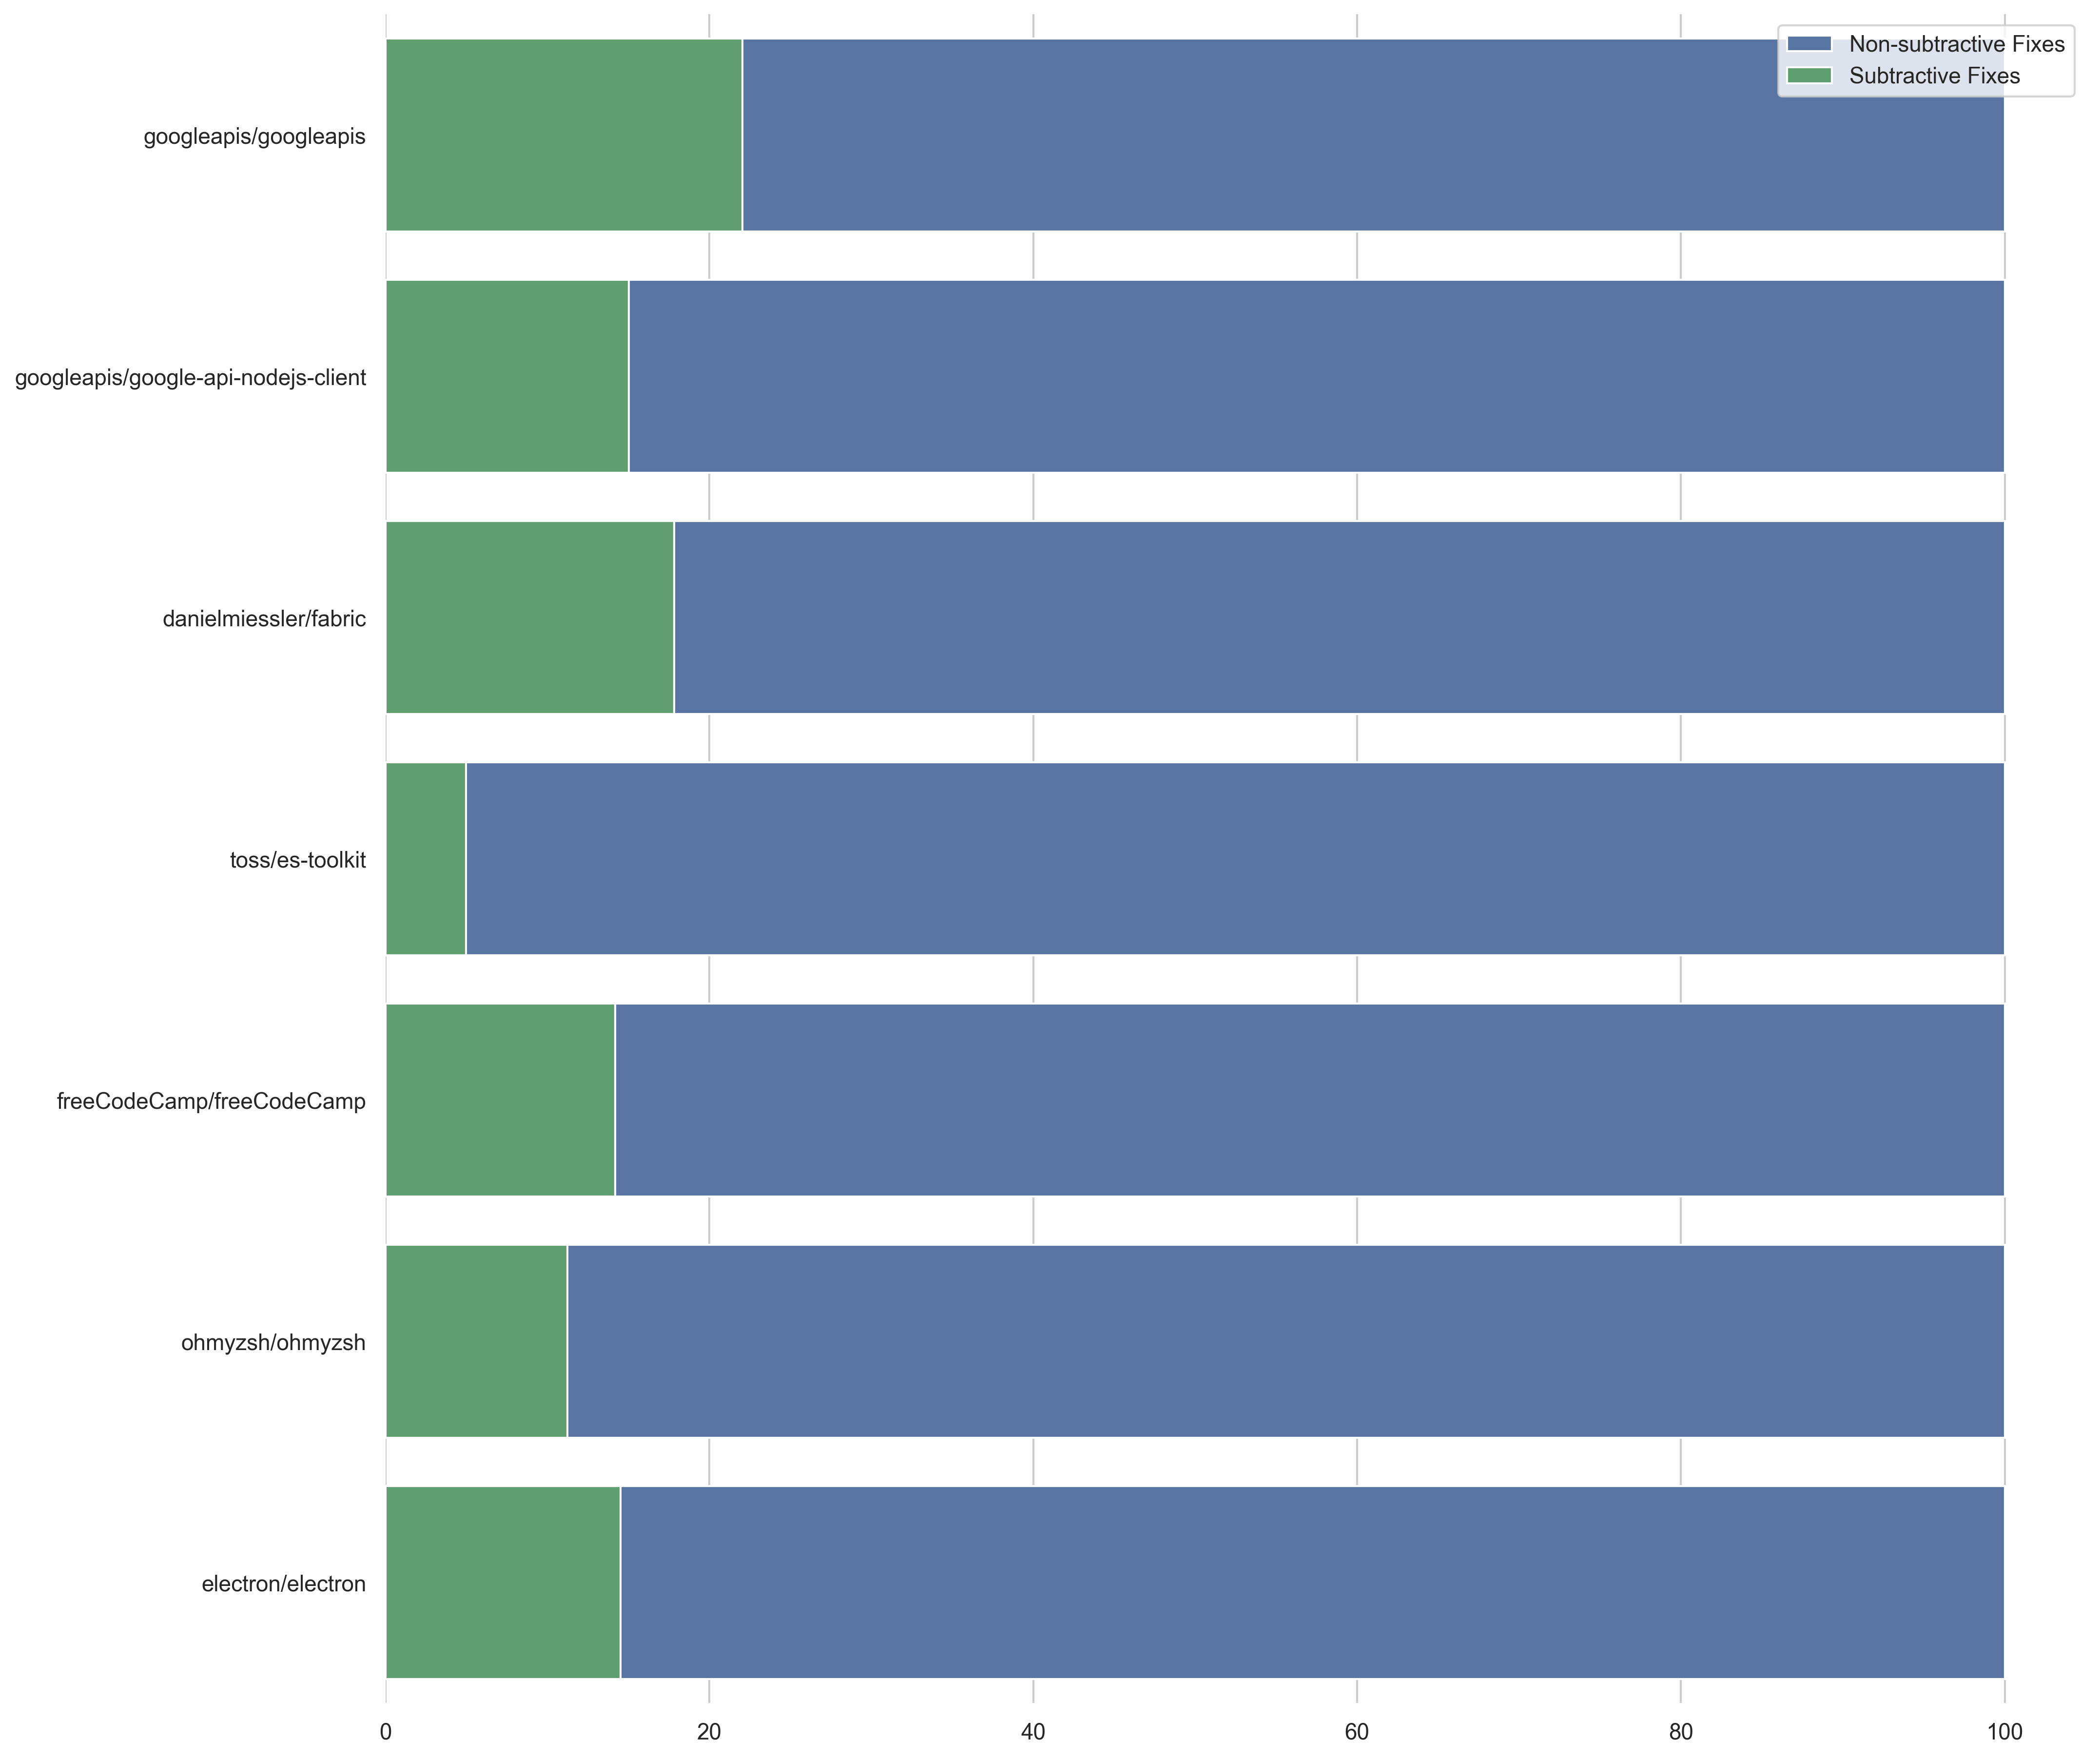

In [29]:
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

df = pd.DataFrame({
    "repo_name": [result.repo_name.removeprefix("https://github.com/") for result in results],
    "subtractive_fixes": [result.num_subtractive_strategy / result.num_problem_solved * 100 for result in results],
    "100%": [1 * 100 for _ in results],
})

sns.set_style("whitegrid")
# Create the stacked bar plot
fig, ax = plt.subplots(1, 1, figsize = (15, 15), dpi=300)
# Plot non-subtractive fixes
sns.barplot(y='repo_name', x='100%', data=df, color='b', label='Non-subtractive Fixes')
# Plot subtractive fixes on top
sns.barplot(y='repo_name', x='subtractive_fixes', data=df, color='g', label='Subtractive Fixes')

plt.legend(loc='upper right')
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_xlim(0, 100)

sns.despine(left=True, bottom=True)


